In [8]:
#%%
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt


In [20]:
class GAN(object):
    
    def __init__(self, height= 10, channels = 1):

        self.SHAPE = (height,channels)
        self.HEIGHT = height
        self.CHANNELS = channels

        self.OPTIMIZER = Adam(lr=0.0002, beta_1 = 0.5,decay=8e-9)

        self.G = self._generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.D = self._discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'])

        self.stacked_G_D = self._stacked_G_D()

        self.stacked_G_D.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)

        self.G_loss = []
        self.D_C_loss = []
        self.D_S_loss = []
        self.EPOCHS = 2000
    def _generator(self):

        model = Sequential()
        #input layer
        model.add(Dense(20, input_shape = (self.HEIGHT,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 2
        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(40))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        #layer 3
        model.add(Dense(80))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(10, activation='tanh'))

        model.add(Reshape(self.SHAPE))
        
        return model

    def _discriminator(self):

        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def _stacked_G_D(self):
        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model
        
    def train(self, data, epochs = 2000,batch = 6, sparse_clean_ratio = 0.3):
        self.EPOCHS = epochs
        for epoch in range(epochs):
            
            # train discriminator
            random_index = np.random.randint(0, len(data) - batch//2)
            clean_mixes = data[random_index : random_index + batch//2]

            # create sparse mixes
            sparse_mix = clean_mixes
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,len(mix),round(len(mix)*sparse_clean_ratio))
                for i in rand_indexs:
                    mix[i]=0
            
            synthetic_mixes = self.G.predict_on_batch(sparse_mix)

            # combined_batch = np.concatenate((clean_mixes.reshape(synthetic_mixes.shape),synthetic_mixes))
            # mask_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))

            # d_loss = self.D.train_on_batch(combined_batch, mask_batch)
            d_loss_clean = self.D.train_on_batch(clean_mixes.reshape(synthetic_mixes.shape),np.ones((np.int64(batch/2), 1)))
            d_loss_synthetic = self.D.train_on_batch(synthetic_mixes,np.zeros((np.int64(batch/2), 1)))

            
            # train generator
            random_index = np.random.randint(0, len(data), size = (1,batch))
            sparse_mix = data[random_index]
            for mix in sparse_mix:
                rand_indexs = np.random.randint(0,high=len(mix),size=round(len(mix)*sparse_clean_ratio))
                mix[rand_indexs] = 0
            y_label = np.ones((batch,1))

            g_loss = self.stacked_G_D.train_on_batch(np.squeeze(sparse_mix),y_label)

            self.G_loss.append(g_loss)
            self.D_C_loss.append(d_loss_clean[0])
            self.D_S_loss.append(d_loss_synthetic[0])
            print ('epoch: %d, [Discriminator :: loss: %f,%f], [ Generator :: loss: %f]' % (epoch, d_loss_clean[0],d_loss_synthetic[0], g_loss))
    def plot(self):
        import matplotlib.pyplot as plt
        plt.style.use('seaborn-whitegrid')
        
        fig = plt.figure()
        ax = plt.axes()

        x = range(self.EPOCHS)
        ax.plot(x,self.G_loss, color = 'orange', label = "Generator")
        ax.plot(x,self.D_C_loss, 'b-', alpha = 0.5, label = "Discriminator - Clean")
        ax.plot(x,self.D_S_loss, 'g-', alpha = 0.5, label = "Discriminator - Synthetic")
        ax.legend(loc = 'center left',bbox_to_anchor=(1,0.5))
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        plt.show()

In [27]:

if __name__ == '__main__':

    # set random seed
    random.seed(1)
    
    
    # Load data from CSV file
    data = pd.read_csv("~/Desktop/Concrete-NN/data/ets.csv", dtype=float)
    # Removing cost for now as it is not important
    data = data.drop('Cost ($/m3)',1)
    # Creating Scaler
    scaler = MinMaxScaler(feature_range = (-1,1))
    # scaling datas
    scaled_data = scaler.fit_transform(data)
    np.random.shuffle(scaled_data)

    gan = GAN()
    gan.train(scaled_data, epochs=5000,batch = 10,sparse_clean_ratio=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 10)                110       
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 55        
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 5)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 6         
Total params: 171
Trainable params: 171
Non-trainable params: 0
_________________________________________________________________


/anaconda3/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: loss: 0.665092,0.706652], [ Generator :: loss: 0.617566]
epoch: 1, [Discriminator :: loss: 0.678014,0.686057], [ Generator :: loss: 0.607602]
epoch: 2, [Discriminator :: loss: 0.646979,0.790553], [ Generator :: loss: 0.631313]
epoch: 3, [Discriminator :: loss: 0.619180,0.767689], [ Generator :: loss: 0.642672]
epoch: 4, [Discriminator :: loss: 0.646604,0.791018], [ Generator :: loss: 0.644235]
epoch: 5, [Discriminator :: loss: 0.664679,0.727120], [ Generator :: loss: 0.613832]
epoch: 6, [Discriminator :: loss: 0.660886,0.792532], [ Generator :: loss: 0.629544]
epoch: 7, [Discriminator :: loss: 0.672885,0.708838], [ Generator :: loss: 0.634566]
epoch: 8, [Discriminator :: loss: 0.649350,0.747043], [ Generator :: loss: 0.598380]
epoch: 9, [Discriminator :: loss: 0.647367,0.783470], [ Generator :: loss: 0.618146]
epoch: 10, [Discriminator :: loss: 0.645004,0.738595], [ Generator :: loss: 0.587977]
epoch: 11, [Discriminator :: loss: 0.661415,0.780142], [ Generat

epoch: 100, [Discriminator :: loss: 0.657715,0.829412], [ Generator :: loss: 0.525913]
epoch: 101, [Discriminator :: loss: 0.678453,0.890718], [ Generator :: loss: 0.547646]
epoch: 102, [Discriminator :: loss: 0.665032,0.864152], [ Generator :: loss: 0.577388]
epoch: 103, [Discriminator :: loss: 0.669957,0.857769], [ Generator :: loss: 0.545681]
epoch: 104, [Discriminator :: loss: 0.697575,0.935585], [ Generator :: loss: 0.554439]
epoch: 105, [Discriminator :: loss: 0.658208,0.854038], [ Generator :: loss: 0.537886]
epoch: 106, [Discriminator :: loss: 0.665831,0.797114], [ Generator :: loss: 0.519436]
epoch: 107, [Discriminator :: loss: 0.655732,0.801146], [ Generator :: loss: 0.549599]
epoch: 108, [Discriminator :: loss: 0.649472,0.855345], [ Generator :: loss: 0.560529]
epoch: 109, [Discriminator :: loss: 0.682564,0.819763], [ Generator :: loss: 0.536821]
epoch: 110, [Discriminator :: loss: 0.650163,0.837995], [ Generator :: loss: 0.549358]
epoch: 111, [Discriminator :: loss: 0.66058

epoch: 202, [Discriminator :: loss: 0.699766,0.856532], [ Generator :: loss: 0.560464]
epoch: 203, [Discriminator :: loss: 0.690078,0.828356], [ Generator :: loss: 0.616935]
epoch: 204, [Discriminator :: loss: 0.687323,0.844972], [ Generator :: loss: 0.551434]
epoch: 205, [Discriminator :: loss: 0.695041,0.856954], [ Generator :: loss: 0.588489]
epoch: 206, [Discriminator :: loss: 0.696113,0.863085], [ Generator :: loss: 0.600471]
epoch: 207, [Discriminator :: loss: 0.688326,0.806742], [ Generator :: loss: 0.588470]
epoch: 208, [Discriminator :: loss: 0.699282,0.821725], [ Generator :: loss: 0.613064]
epoch: 209, [Discriminator :: loss: 0.696548,0.862316], [ Generator :: loss: 0.557634]
epoch: 210, [Discriminator :: loss: 0.696536,0.895406], [ Generator :: loss: 0.545753]
epoch: 211, [Discriminator :: loss: 0.699403,0.841220], [ Generator :: loss: 0.611522]
epoch: 212, [Discriminator :: loss: 0.690406,0.804997], [ Generator :: loss: 0.583866]
epoch: 213, [Discriminator :: loss: 0.69598

epoch: 306, [Discriminator :: loss: 0.703021,0.781614], [ Generator :: loss: 0.616965]
epoch: 307, [Discriminator :: loss: 0.702211,0.797328], [ Generator :: loss: 0.582598]
epoch: 308, [Discriminator :: loss: 0.708393,0.759377], [ Generator :: loss: 0.669223]
epoch: 309, [Discriminator :: loss: 0.700351,0.781527], [ Generator :: loss: 0.612204]
epoch: 310, [Discriminator :: loss: 0.697677,0.785635], [ Generator :: loss: 0.655156]
epoch: 311, [Discriminator :: loss: 0.699269,0.799607], [ Generator :: loss: 0.630171]
epoch: 312, [Discriminator :: loss: 0.698704,0.757106], [ Generator :: loss: 0.611392]
epoch: 313, [Discriminator :: loss: 0.699358,0.814103], [ Generator :: loss: 0.589409]
epoch: 314, [Discriminator :: loss: 0.700912,0.782133], [ Generator :: loss: 0.612919]
epoch: 315, [Discriminator :: loss: 0.697149,0.798770], [ Generator :: loss: 0.611528]
epoch: 316, [Discriminator :: loss: 0.699430,0.820502], [ Generator :: loss: 0.609559]
epoch: 317, [Discriminator :: loss: 0.69945

epoch: 415, [Discriminator :: loss: 0.704296,0.664908], [ Generator :: loss: 0.688832]
epoch: 416, [Discriminator :: loss: 0.705957,0.679097], [ Generator :: loss: 0.694224]
epoch: 417, [Discriminator :: loss: 0.701324,0.701497], [ Generator :: loss: 0.687484]
epoch: 418, [Discriminator :: loss: 0.701341,0.684450], [ Generator :: loss: 0.738133]
epoch: 419, [Discriminator :: loss: 0.706623,0.694499], [ Generator :: loss: 0.702972]
epoch: 420, [Discriminator :: loss: 0.701642,0.684744], [ Generator :: loss: 0.690785]
epoch: 421, [Discriminator :: loss: 0.701484,0.674543], [ Generator :: loss: 0.708256]
epoch: 422, [Discriminator :: loss: 0.701483,0.682660], [ Generator :: loss: 0.719016]
epoch: 423, [Discriminator :: loss: 0.701477,0.680281], [ Generator :: loss: 0.678304]
epoch: 424, [Discriminator :: loss: 0.701480,0.690955], [ Generator :: loss: 0.719854]
epoch: 425, [Discriminator :: loss: 0.701461,0.691669], [ Generator :: loss: 0.705582]
epoch: 426, [Discriminator :: loss: 0.70145

epoch: 535, [Discriminator :: loss: 0.702593,0.647613], [ Generator :: loss: 0.743939]
epoch: 536, [Discriminator :: loss: 0.701366,0.621976], [ Generator :: loss: 0.733993]
epoch: 537, [Discriminator :: loss: 0.701345,0.603348], [ Generator :: loss: 0.743556]
epoch: 538, [Discriminator :: loss: 0.706833,0.627345], [ Generator :: loss: 0.743169]
epoch: 539, [Discriminator :: loss: 0.701288,0.613221], [ Generator :: loss: 0.742507]
epoch: 540, [Discriminator :: loss: 0.701237,0.618006], [ Generator :: loss: 0.772616]
epoch: 541, [Discriminator :: loss: 0.701199,0.600014], [ Generator :: loss: 0.735686]
epoch: 542, [Discriminator :: loss: 0.701164,0.592284], [ Generator :: loss: 0.789897]
epoch: 543, [Discriminator :: loss: 0.701260,0.632869], [ Generator :: loss: 0.758500]
epoch: 544, [Discriminator :: loss: 0.701108,0.604930], [ Generator :: loss: 0.742745]
epoch: 545, [Discriminator :: loss: 0.701190,0.606474], [ Generator :: loss: 0.792172]
epoch: 546, [Discriminator :: loss: 0.70117

epoch: 635, [Discriminator :: loss: 0.698289,0.465014], [ Generator :: loss: 0.730094]
epoch: 636, [Discriminator :: loss: 0.706456,0.517450], [ Generator :: loss: 0.864545]
epoch: 637, [Discriminator :: loss: 0.698318,0.459756], [ Generator :: loss: 0.730107]
epoch: 638, [Discriminator :: loss: 0.698270,0.454735], [ Generator :: loss: 0.730066]
epoch: 639, [Discriminator :: loss: 0.698199,0.448364], [ Generator :: loss: 0.662902]
epoch: 640, [Discriminator :: loss: 0.698105,0.453138], [ Generator :: loss: 0.729795]
epoch: 641, [Discriminator :: loss: 0.698134,0.450694], [ Generator :: loss: 0.729702]
epoch: 642, [Discriminator :: loss: 0.698069,0.448536], [ Generator :: loss: 0.843415]
epoch: 643, [Discriminator :: loss: 0.697989,0.451701], [ Generator :: loss: 0.851207]
epoch: 644, [Discriminator :: loss: 0.697940,0.458193], [ Generator :: loss: 0.729836]
epoch: 645, [Discriminator :: loss: 0.697965,0.449639], [ Generator :: loss: 0.838194]
epoch: 646, [Discriminator :: loss: 0.71088

epoch: 739, [Discriminator :: loss: 0.695344,0.355265], [ Generator :: loss: 0.704157]
epoch: 740, [Discriminator :: loss: 0.695200,0.342770], [ Generator :: loss: 0.703693]
epoch: 741, [Discriminator :: loss: 0.695161,0.336126], [ Generator :: loss: 0.613311]
epoch: 742, [Discriminator :: loss: 0.695021,0.336388], [ Generator :: loss: 0.795556]
epoch: 743, [Discriminator :: loss: 0.694979,0.322729], [ Generator :: loss: 0.757302]
epoch: 744, [Discriminator :: loss: 0.694858,0.390304], [ Generator :: loss: 0.701875]
epoch: 745, [Discriminator :: loss: 0.694879,0.356999], [ Generator :: loss: 0.816895]
epoch: 746, [Discriminator :: loss: 0.694749,0.407661], [ Generator :: loss: 0.700872]
epoch: 747, [Discriminator :: loss: 0.694636,0.379685], [ Generator :: loss: 0.700359]
epoch: 748, [Discriminator :: loss: 0.696226,0.439938], [ Generator :: loss: 0.781063]
epoch: 749, [Discriminator :: loss: 0.694477,0.463657], [ Generator :: loss: 0.724579]
epoch: 750, [Discriminator :: loss: 0.69449

epoch: 843, [Discriminator :: loss: 0.690268,0.247298], [ Generator :: loss: 0.680604]
epoch: 844, [Discriminator :: loss: 0.690132,0.231383], [ Generator :: loss: 0.680415]
epoch: 845, [Discriminator :: loss: 0.690036,0.227798], [ Generator :: loss: 0.698739]
epoch: 846, [Discriminator :: loss: 0.689999,0.368258], [ Generator :: loss: 0.680017]
epoch: 847, [Discriminator :: loss: 0.689827,0.314330], [ Generator :: loss: 0.696855]
epoch: 848, [Discriminator :: loss: 0.689706,0.370989], [ Generator :: loss: 0.679645]
epoch: 849, [Discriminator :: loss: 0.689646,0.321678], [ Generator :: loss: 0.679465]
epoch: 850, [Discriminator :: loss: 0.689489,0.278422], [ Generator :: loss: 0.705910]
epoch: 851, [Discriminator :: loss: 0.689468,0.368044], [ Generator :: loss: 0.684429]
epoch: 852, [Discriminator :: loss: 0.689314,0.407382], [ Generator :: loss: 0.678943]
epoch: 853, [Discriminator :: loss: 0.689400,0.418834], [ Generator :: loss: 0.679754]
epoch: 854, [Discriminator :: loss: 0.68932

epoch: 947, [Discriminator :: loss: 0.681530,0.249734], [ Generator :: loss: 0.616067]
epoch: 948, [Discriminator :: loss: 0.681389,0.238031], [ Generator :: loss: 0.615308]
epoch: 949, [Discriminator :: loss: 0.681308,0.232243], [ Generator :: loss: 0.614447]
epoch: 950, [Discriminator :: loss: 0.681091,0.227851], [ Generator :: loss: 0.650767]
epoch: 951, [Discriminator :: loss: 0.680939,0.351248], [ Generator :: loss: 0.612977]
epoch: 952, [Discriminator :: loss: 0.680944,0.300846], [ Generator :: loss: 0.649315]
epoch: 953, [Discriminator :: loss: 0.680758,0.337266], [ Generator :: loss: 0.721107]
epoch: 954, [Discriminator :: loss: 0.680625,0.366263], [ Generator :: loss: 0.611066]
epoch: 955, [Discriminator :: loss: 0.680586,0.329087], [ Generator :: loss: 0.648421]
epoch: 956, [Discriminator :: loss: 0.680477,0.367791], [ Generator :: loss: 0.609996]
epoch: 957, [Discriminator :: loss: 0.680479,0.318129], [ Generator :: loss: 0.647970]
epoch: 958, [Discriminator :: loss: 0.68031

epoch: 1047, [Discriminator :: loss: 0.670663,0.120977], [ Generator :: loss: 0.640143]
epoch: 1048, [Discriminator :: loss: 0.678244,0.273824], [ Generator :: loss: 0.548493]
epoch: 1049, [Discriminator :: loss: 0.670304,0.281623], [ Generator :: loss: 0.547645]
epoch: 1050, [Discriminator :: loss: 0.670203,0.257791], [ Generator :: loss: 0.546720]
epoch: 1051, [Discriminator :: loss: 0.670027,0.237430], [ Generator :: loss: 0.545746]
epoch: 1052, [Discriminator :: loss: 0.669845,0.191451], [ Generator :: loss: 0.544790]
epoch: 1053, [Discriminator :: loss: 0.669688,0.129419], [ Generator :: loss: 0.543819]
epoch: 1054, [Discriminator :: loss: 0.669552,0.108147], [ Generator :: loss: 0.542828]
epoch: 1055, [Discriminator :: loss: 0.669286,0.102617], [ Generator :: loss: 0.541869]
epoch: 1056, [Discriminator :: loss: 0.669085,0.101748], [ Generator :: loss: 0.540912]
epoch: 1057, [Discriminator :: loss: 0.668882,0.101156], [ Generator :: loss: 0.539964]
epoch: 1058, [Discriminator :: l

epoch: 1151, [Discriminator :: loss: 0.662825,0.166105], [ Generator :: loss: 0.485640]
epoch: 1152, [Discriminator :: loss: 0.662645,0.748133], [ Generator :: loss: 0.502880]
epoch: 1153, [Discriminator :: loss: 0.662722,0.902208], [ Generator :: loss: 0.512413]
epoch: 1154, [Discriminator :: loss: 0.662764,0.857220], [ Generator :: loss: 0.489048]
epoch: 1155, [Discriminator :: loss: 0.662873,0.721473], [ Generator :: loss: 0.503431]
epoch: 1156, [Discriminator :: loss: 0.663037,0.806029], [ Generator :: loss: 0.486022]
epoch: 1157, [Discriminator :: loss: 0.663235,0.821308], [ Generator :: loss: 0.490130]
epoch: 1158, [Discriminator :: loss: 0.663439,0.799680], [ Generator :: loss: 0.504018]
epoch: 1159, [Discriminator :: loss: 0.663620,0.859924], [ Generator :: loss: 0.504080]
epoch: 1160, [Discriminator :: loss: 0.663752,0.873813], [ Generator :: loss: 0.523406]
epoch: 1161, [Discriminator :: loss: 0.663856,0.884874], [ Generator :: loss: 0.492116]
epoch: 1162, [Discriminator :: l

epoch: 1252, [Discriminator :: loss: 0.654834,0.063170], [ Generator :: loss: 0.498852]
epoch: 1253, [Discriminator :: loss: 0.654616,0.291557], [ Generator :: loss: 0.445200]
epoch: 1254, [Discriminator :: loss: 0.654471,0.300142], [ Generator :: loss: 0.444916]
epoch: 1255, [Discriminator :: loss: 0.654243,0.306844], [ Generator :: loss: 0.444578]
epoch: 1256, [Discriminator :: loss: 0.654072,0.306793], [ Generator :: loss: 0.444202]
epoch: 1257, [Discriminator :: loss: 0.653890,0.289387], [ Generator :: loss: 0.443871]
epoch: 1258, [Discriminator :: loss: 0.653739,0.146525], [ Generator :: loss: 0.443427]
epoch: 1259, [Discriminator :: loss: 0.653506,0.125745], [ Generator :: loss: 0.445828]
epoch: 1260, [Discriminator :: loss: 0.653317,0.137903], [ Generator :: loss: 0.442442]
epoch: 1261, [Discriminator :: loss: 0.653131,0.136967], [ Generator :: loss: 0.443956]
epoch: 1262, [Discriminator :: loss: 0.652952,0.160463], [ Generator :: loss: 0.441501]
epoch: 1263, [Discriminator :: l

epoch: 1356, [Discriminator :: loss: 0.637401,0.074839], [ Generator :: loss: 0.419070]
epoch: 1357, [Discriminator :: loss: 0.637162,0.075718], [ Generator :: loss: 0.418540]
epoch: 1358, [Discriminator :: loss: 0.636928,0.081320], [ Generator :: loss: 0.418053]
epoch: 1359, [Discriminator :: loss: 0.636725,0.134458], [ Generator :: loss: 0.458804]
epoch: 1360, [Discriminator :: loss: 0.636453,0.616272], [ Generator :: loss: 0.417728]
epoch: 1361, [Discriminator :: loss: 0.636357,0.630538], [ Generator :: loss: 0.418412]
epoch: 1362, [Discriminator :: loss: 0.636438,0.640206], [ Generator :: loss: 0.422898]
epoch: 1363, [Discriminator :: loss: 0.636232,0.057480], [ Generator :: loss: 0.419229]
epoch: 1364, [Discriminator :: loss: 0.635984,0.057342], [ Generator :: loss: 0.434795]
epoch: 1365, [Discriminator :: loss: 0.635750,0.057918], [ Generator :: loss: 0.418249]
epoch: 1366, [Discriminator :: loss: 0.635508,0.056973], [ Generator :: loss: 0.417740]
epoch: 1367, [Discriminator :: l

epoch: 1458, [Discriminator :: loss: 0.618145,0.061881], [ Generator :: loss: 0.424938]
epoch: 1459, [Discriminator :: loss: 0.617867,0.066177], [ Generator :: loss: 0.424268]
epoch: 1460, [Discriminator :: loss: 0.617590,0.070332], [ Generator :: loss: 0.423604]
epoch: 1461, [Discriminator :: loss: 0.617314,0.074882], [ Generator :: loss: 0.422949]
epoch: 1462, [Discriminator :: loss: 0.617037,0.076185], [ Generator :: loss: 0.413753]
epoch: 1463, [Discriminator :: loss: 0.616759,0.046336], [ Generator :: loss: 0.421714]
epoch: 1464, [Discriminator :: loss: 0.616473,0.050357], [ Generator :: loss: 0.421078]
epoch: 1465, [Discriminator :: loss: 0.616190,0.050373], [ Generator :: loss: 0.420403]
epoch: 1466, [Discriminator :: loss: 0.615907,0.050208], [ Generator :: loss: 0.419711]
epoch: 1467, [Discriminator :: loss: 0.615625,0.050015], [ Generator :: loss: 0.419011]
epoch: 1468, [Discriminator :: loss: 0.615342,0.049822], [ Generator :: loss: 0.418308]
epoch: 1469, [Discriminator :: l

epoch: 1563, [Discriminator :: loss: 0.588633,0.044073], [ Generator :: loss: 0.355075]
epoch: 1564, [Discriminator :: loss: 0.588323,0.068741], [ Generator :: loss: 0.354476]
epoch: 1565, [Discriminator :: loss: 0.588048,0.108806], [ Generator :: loss: 0.353881]
epoch: 1566, [Discriminator :: loss: 0.587841,0.140798], [ Generator :: loss: 0.353316]
epoch: 1567, [Discriminator :: loss: 0.587701,0.156547], [ Generator :: loss: 0.352772]
epoch: 1568, [Discriminator :: loss: 0.587477,0.167083], [ Generator :: loss: 0.352232]
epoch: 1569, [Discriminator :: loss: 0.587248,0.146487], [ Generator :: loss: 0.351697]
epoch: 1570, [Discriminator :: loss: 0.587021,0.130645], [ Generator :: loss: 0.351148]
epoch: 1571, [Discriminator :: loss: 0.586686,0.131415], [ Generator :: loss: 0.350611]
epoch: 1572, [Discriminator :: loss: 0.586397,0.143767], [ Generator :: loss: 0.350086]
epoch: 1573, [Discriminator :: loss: 0.586126,0.171694], [ Generator :: loss: 0.349580]
epoch: 1574, [Discriminator :: l

epoch: 1667, [Discriminator :: loss: 0.561187,1.258159], [ Generator :: loss: 0.332361]
epoch: 1668, [Discriminator :: loss: 0.561482,1.251508], [ Generator :: loss: 0.353578]
epoch: 1669, [Discriminator :: loss: 0.561760,0.054242], [ Generator :: loss: 0.337730]
epoch: 1670, [Discriminator :: loss: 0.561711,0.055238], [ Generator :: loss: 0.337797]
epoch: 1671, [Discriminator :: loss: 0.561433,0.063714], [ Generator :: loss: 0.337441]
epoch: 1672, [Discriminator :: loss: 0.561111,0.070645], [ Generator :: loss: 0.336941]
epoch: 1673, [Discriminator :: loss: 0.560784,0.070642], [ Generator :: loss: 0.336380]
epoch: 1674, [Discriminator :: loss: 0.560451,0.037415], [ Generator :: loss: 0.335836]
epoch: 1675, [Discriminator :: loss: 0.560114,0.030111], [ Generator :: loss: 0.335318]
epoch: 1676, [Discriminator :: loss: 0.559769,0.029871], [ Generator :: loss: 0.334808]
epoch: 1677, [Discriminator :: loss: 0.559420,0.029998], [ Generator :: loss: 0.334299]
epoch: 1678, [Discriminator :: l

epoch: 1771, [Discriminator :: loss: 0.530410,0.043075], [ Generator :: loss: 0.333485]
epoch: 1772, [Discriminator :: loss: 0.530044,0.040486], [ Generator :: loss: 0.308482]
epoch: 1773, [Discriminator :: loss: 0.529670,0.040341], [ Generator :: loss: 0.308100]
epoch: 1774, [Discriminator :: loss: 0.529290,0.042702], [ Generator :: loss: 0.307722]
epoch: 1775, [Discriminator :: loss: 0.528910,0.040714], [ Generator :: loss: 0.307314]
epoch: 1776, [Discriminator :: loss: 0.528533,0.042402], [ Generator :: loss: 0.306867]
epoch: 1777, [Discriminator :: loss: 0.528161,0.042298], [ Generator :: loss: 0.306403]
epoch: 1778, [Discriminator :: loss: 0.527791,0.042124], [ Generator :: loss: 0.305933]
epoch: 1779, [Discriminator :: loss: 0.527422,0.041951], [ Generator :: loss: 0.305463]
epoch: 1780, [Discriminator :: loss: 0.527052,0.039956], [ Generator :: loss: 0.304994]
epoch: 1781, [Discriminator :: loss: 0.526680,0.030848], [ Generator :: loss: 0.304540]
epoch: 1782, [Discriminator :: l

epoch: 1876, [Discriminator :: loss: 0.473130,0.018412], [ Generator :: loss: 0.256780]
epoch: 1877, [Discriminator :: loss: 0.472456,0.018876], [ Generator :: loss: 0.256224]
epoch: 1878, [Discriminator :: loss: 0.471783,0.020221], [ Generator :: loss: 0.255665]
epoch: 1879, [Discriminator :: loss: 0.471113,0.025611], [ Generator :: loss: 0.255071]
epoch: 1880, [Discriminator :: loss: 0.470458,0.059575], [ Generator :: loss: 0.254462]
epoch: 1881, [Discriminator :: loss: 0.469864,0.101474], [ Generator :: loss: 0.253879]
epoch: 1882, [Discriminator :: loss: 0.469408,0.108161], [ Generator :: loss: 0.253294]
epoch: 1883, [Discriminator :: loss: 0.468906,0.101168], [ Generator :: loss: 0.277255]
epoch: 1884, [Discriminator :: loss: 0.468478,0.029845], [ Generator :: loss: 0.252129]
epoch: 1885, [Discriminator :: loss: 0.467802,0.030238], [ Generator :: loss: 0.251573]
epoch: 1886, [Discriminator :: loss: 0.467151,0.034134], [ Generator :: loss: 0.276990]
epoch: 1887, [Discriminator :: l

epoch: 1983, [Discriminator :: loss: 0.406802,0.029327], [ Generator :: loss: 0.178545]
epoch: 1984, [Discriminator :: loss: 0.406219,0.022743], [ Generator :: loss: 0.192807]
epoch: 1985, [Discriminator :: loss: 0.405635,0.022721], [ Generator :: loss: 0.177204]
epoch: 1986, [Discriminator :: loss: 0.405045,0.022844], [ Generator :: loss: 0.176547]
epoch: 1987, [Discriminator :: loss: 0.404453,0.026391], [ Generator :: loss: 0.175878]
epoch: 1988, [Discriminator :: loss: 0.403862,0.028638], [ Generator :: loss: 0.175202]
epoch: 1989, [Discriminator :: loss: 0.403274,0.028723], [ Generator :: loss: 0.174523]
epoch: 1990, [Discriminator :: loss: 0.402687,0.028397], [ Generator :: loss: 0.173845]
epoch: 1991, [Discriminator :: loss: 0.402101,0.023800], [ Generator :: loss: 0.173172]
epoch: 1992, [Discriminator :: loss: 0.401515,0.017267], [ Generator :: loss: 0.172511]
epoch: 1993, [Discriminator :: loss: 0.400930,0.030210], [ Generator :: loss: 0.171849]
epoch: 1994, [Discriminator :: l

epoch: 2091, [Discriminator :: loss: 0.346369,0.021107], [ Generator :: loss: 0.121250]
epoch: 2092, [Discriminator :: loss: 0.345827,0.021138], [ Generator :: loss: 0.120834]
epoch: 2093, [Discriminator :: loss: 0.345286,0.020775], [ Generator :: loss: 0.120418]
epoch: 2094, [Discriminator :: loss: 0.344745,0.017878], [ Generator :: loss: 0.120005]
epoch: 2095, [Discriminator :: loss: 0.344205,0.022068], [ Generator :: loss: 0.119590]
epoch: 2096, [Discriminator :: loss: 0.343668,0.024749], [ Generator :: loss: 0.119168]
epoch: 2097, [Discriminator :: loss: 0.343135,0.024333], [ Generator :: loss: 0.118742]
epoch: 2098, [Discriminator :: loss: 0.342603,0.020670], [ Generator :: loss: 0.118324]
epoch: 2099, [Discriminator :: loss: 0.342071,0.012964], [ Generator :: loss: 0.117921]
epoch: 2100, [Discriminator :: loss: 0.341536,0.011716], [ Generator :: loss: 0.117528]
epoch: 2101, [Discriminator :: loss: 0.341000,0.011532], [ Generator :: loss: 0.117138]
epoch: 2102, [Discriminator :: l

epoch: 2199, [Discriminator :: loss: 0.292748,0.012666], [ Generator :: loss: 0.082636]
epoch: 2200, [Discriminator :: loss: 0.292275,0.012676], [ Generator :: loss: 0.082360]
epoch: 2201, [Discriminator :: loss: 0.291786,0.013214], [ Generator :: loss: 0.082088]
epoch: 2202, [Discriminator :: loss: 0.291294,0.015116], [ Generator :: loss: 0.081814]
epoch: 2203, [Discriminator :: loss: 0.290801,0.015283], [ Generator :: loss: 0.081538]
epoch: 2204, [Discriminator :: loss: 0.290310,0.012776], [ Generator :: loss: 0.081262]
epoch: 2205, [Discriminator :: loss: 0.289819,0.010128], [ Generator :: loss: 0.080991]
epoch: 2206, [Discriminator :: loss: 0.289328,0.012570], [ Generator :: loss: 0.080721]
epoch: 2207, [Discriminator :: loss: 0.288838,0.015398], [ Generator :: loss: 0.080446]
epoch: 2208, [Discriminator :: loss: 0.288349,0.015188], [ Generator :: loss: 0.080170]
epoch: 2209, [Discriminator :: loss: 0.287862,0.012970], [ Generator :: loss: 0.079897]
epoch: 2210, [Discriminator :: l

epoch: 2306, [Discriminator :: loss: 0.304750,0.013774], [ Generator :: loss: 0.291984]
epoch: 2307, [Discriminator :: loss: 0.304394,0.013919], [ Generator :: loss: 0.291020]
epoch: 2308, [Discriminator :: loss: 0.304036,0.015156], [ Generator :: loss: 0.290045]
epoch: 2309, [Discriminator :: loss: 0.303679,0.018736], [ Generator :: loss: 0.289053]
epoch: 2310, [Discriminator :: loss: 0.303323,0.019157], [ Generator :: loss: 0.288048]
epoch: 2311, [Discriminator :: loss: 0.302969,0.017773], [ Generator :: loss: 0.287039]
epoch: 2312, [Discriminator :: loss: 0.302615,0.014434], [ Generator :: loss: 0.282050]
epoch: 2313, [Discriminator :: loss: 0.302261,0.013530], [ Generator :: loss: 0.285050]
epoch: 2314, [Discriminator :: loss: 0.301904,0.013490], [ Generator :: loss: 0.284056]
epoch: 2315, [Discriminator :: loss: 0.301547,0.013605], [ Generator :: loss: 0.277582]
epoch: 2316, [Discriminator :: loss: 0.301190,0.015086], [ Generator :: loss: 0.282068]
epoch: 2317, [Discriminator :: l

epoch: 2414, [Discriminator :: loss: 0.268082,0.013280], [ Generator :: loss: 0.173245]
epoch: 2415, [Discriminator :: loss: 0.267747,0.014635], [ Generator :: loss: 0.172294]
epoch: 2416, [Discriminator :: loss: 0.267413,0.014606], [ Generator :: loss: 0.171345]
epoch: 2417, [Discriminator :: loss: 0.267083,0.014545], [ Generator :: loss: 0.170402]
epoch: 2418, [Discriminator :: loss: 0.266754,0.014484], [ Generator :: loss: 0.169465]
epoch: 2419, [Discriminator :: loss: 0.266425,0.014408], [ Generator :: loss: 0.168535]
epoch: 2420, [Discriminator :: loss: 0.266096,0.013623], [ Generator :: loss: 0.167612]
epoch: 2421, [Discriminator :: loss: 0.265767,0.012328], [ Generator :: loss: 0.166692]
epoch: 2422, [Discriminator :: loss: 0.265431,0.011280], [ Generator :: loss: 0.165777]
epoch: 2423, [Discriminator :: loss: 0.265092,0.012241], [ Generator :: loss: 0.164869]
epoch: 2424, [Discriminator :: loss: 0.264752,0.013372], [ Generator :: loss: 0.163972]
epoch: 2425, [Discriminator :: l

epoch: 2525, [Discriminator :: loss: 0.239452,0.008895], [ Generator :: loss: 0.115709]
epoch: 2526, [Discriminator :: loss: 0.239139,0.008875], [ Generator :: loss: 0.115278]
epoch: 2527, [Discriminator :: loss: 0.238822,0.008859], [ Generator :: loss: 0.114918]
epoch: 2528, [Discriminator :: loss: 0.238504,0.008844], [ Generator :: loss: 0.114502]
epoch: 2529, [Discriminator :: loss: 0.238185,0.008830], [ Generator :: loss: 0.114211]
epoch: 2530, [Discriminator :: loss: 0.237867,0.008816], [ Generator :: loss: 0.113838]
epoch: 2531, [Discriminator :: loss: 0.237549,0.008798], [ Generator :: loss: 0.113420]
epoch: 2532, [Discriminator :: loss: 0.237231,0.008511], [ Generator :: loss: 0.113100]
epoch: 2533, [Discriminator :: loss: 0.236913,0.007445], [ Generator :: loss: 0.112686]
epoch: 2534, [Discriminator :: loss: 0.236595,0.007209], [ Generator :: loss: 0.112373]
epoch: 2535, [Discriminator :: loss: 0.236276,0.007914], [ Generator :: loss: 0.112006]
epoch: 2536, [Discriminator :: l

epoch: 2619, [Discriminator :: loss: 0.228038,0.029760], [ Generator :: loss: 0.133500]
epoch: 2620, [Discriminator :: loss: 0.227794,0.027857], [ Generator :: loss: 0.133184]
epoch: 2621, [Discriminator :: loss: 0.227544,0.027650], [ Generator :: loss: 0.132829]
epoch: 2622, [Discriminator :: loss: 0.227290,0.030257], [ Generator :: loss: 0.132491]
epoch: 2623, [Discriminator :: loss: 0.227035,0.038941], [ Generator :: loss: 0.132178]
epoch: 2624, [Discriminator :: loss: 0.226786,0.072731], [ Generator :: loss: 0.131821]
epoch: 2625, [Discriminator :: loss: 0.226568,0.175459], [ Generator :: loss: 0.131603]
epoch: 2626, [Discriminator :: loss: 0.226435,0.388141], [ Generator :: loss: 0.131641]
epoch: 2627, [Discriminator :: loss: 0.226566,0.713030], [ Generator :: loss: 0.132151]
epoch: 2628, [Discriminator :: loss: 0.227058,1.293028], [ Generator :: loss: 0.133478]
epoch: 2629, [Discriminator :: loss: 0.228076,1.949023], [ Generator :: loss: 0.135990]
epoch: 2630, [Discriminator :: l

epoch: 2722, [Discriminator :: loss: 0.220410,0.007219], [ Generator :: loss: 0.195378]
epoch: 2723, [Discriminator :: loss: 0.220144,0.016964], [ Generator :: loss: 0.194999]
epoch: 2724, [Discriminator :: loss: 0.219891,0.027346], [ Generator :: loss: 0.194747]
epoch: 2725, [Discriminator :: loss: 0.219658,0.040822], [ Generator :: loss: 0.194373]
epoch: 2726, [Discriminator :: loss: 0.219451,0.038644], [ Generator :: loss: 0.194071]
epoch: 2727, [Discriminator :: loss: 0.219252,0.028223], [ Generator :: loss: 0.193867]
epoch: 2728, [Discriminator :: loss: 0.219039,0.031933], [ Generator :: loss: 0.193476]
epoch: 2729, [Discriminator :: loss: 0.218815,0.033070], [ Generator :: loss: 0.193132]
epoch: 2730, [Discriminator :: loss: 0.218592,0.034359], [ Generator :: loss: 0.192897]
epoch: 2731, [Discriminator :: loss: 0.218368,0.037766], [ Generator :: loss: 0.183480]
epoch: 2732, [Discriminator :: loss: 0.218145,0.004502], [ Generator :: loss: 0.192209]
epoch: 2733, [Discriminator :: l

epoch: 2826, [Discriminator :: loss: 0.212407,0.067101], [ Generator :: loss: 0.253114]
epoch: 2827, [Discriminator :: loss: 0.212213,0.145887], [ Generator :: loss: 0.252224]
epoch: 2828, [Discriminator :: loss: 0.212135,0.303569], [ Generator :: loss: 0.251780]
epoch: 2829, [Discriminator :: loss: 0.212189,0.500966], [ Generator :: loss: 0.251688]
epoch: 2830, [Discriminator :: loss: 0.212476,0.724885], [ Generator :: loss: 0.251986]
epoch: 2831, [Discriminator :: loss: 0.212991,1.123533], [ Generator :: loss: 0.253562]
epoch: 2832, [Discriminator :: loss: 0.214131,1.646154], [ Generator :: loss: 0.256929]
epoch: 2833, [Discriminator :: loss: 0.215376,1.613370], [ Generator :: loss: 0.261583]
epoch: 2834, [Discriminator :: loss: 0.216317,1.512242], [ Generator :: loss: 0.270363]
epoch: 2835, [Discriminator :: loss: 0.217037,1.439700], [ Generator :: loss: 0.280467]
epoch: 2836, [Discriminator :: loss: 0.217635,1.394527], [ Generator :: loss: 0.290942]
epoch: 2837, [Discriminator :: l

epoch: 2922, [Discriminator :: loss: 0.215807,1.349753], [ Generator :: loss: 0.312534]
epoch: 2923, [Discriminator :: loss: 0.216329,1.330874], [ Generator :: loss: 0.317250]
epoch: 2924, [Discriminator :: loss: 0.216834,1.313333], [ Generator :: loss: 0.322391]
epoch: 2925, [Discriminator :: loss: 0.217322,1.298585], [ Generator :: loss: 0.302518]
epoch: 2926, [Discriminator :: loss: 0.217797,0.002635], [ Generator :: loss: 0.328438]
epoch: 2927, [Discriminator :: loss: 0.217760,0.003096], [ Generator :: loss: 0.325870]
epoch: 2928, [Discriminator :: loss: 0.217433,0.002829], [ Generator :: loss: 0.324408]
epoch: 2929, [Discriminator :: loss: 0.217087,0.002615], [ Generator :: loss: 0.321941]
epoch: 2930, [Discriminator :: loss: 0.216724,0.002516], [ Generator :: loss: 0.280533]
epoch: 2931, [Discriminator :: loss: 0.216358,0.005843], [ Generator :: loss: 0.317663]
epoch: 2932, [Discriminator :: loss: 0.215994,0.004490], [ Generator :: loss: 0.315663]
epoch: 2933, [Discriminator :: l

epoch: 3020, [Discriminator :: loss: 0.194755,0.002420], [ Generator :: loss: 0.185732]
epoch: 3021, [Discriminator :: loss: 0.194521,0.002434], [ Generator :: loss: 0.185003]
epoch: 3022, [Discriminator :: loss: 0.194287,0.002431], [ Generator :: loss: 0.183812]
epoch: 3023, [Discriminator :: loss: 0.194053,0.002414], [ Generator :: loss: 0.182998]
epoch: 3024, [Discriminator :: loss: 0.193819,0.002411], [ Generator :: loss: 0.182040]
epoch: 3025, [Discriminator :: loss: 0.193586,0.002425], [ Generator :: loss: 0.180956]
epoch: 3026, [Discriminator :: loss: 0.193352,0.004189], [ Generator :: loss: 0.180161]
epoch: 3027, [Discriminator :: loss: 0.193121,0.020413], [ Generator :: loss: 0.179193]
epoch: 3028, [Discriminator :: loss: 0.192915,0.027482], [ Generator :: loss: 0.178332]
epoch: 3029, [Discriminator :: loss: 0.192712,0.028885], [ Generator :: loss: 0.177381]
epoch: 3030, [Discriminator :: loss: 0.192528,0.036783], [ Generator :: loss: 0.176878]
epoch: 3031, [Discriminator :: l

epoch: 3117, [Discriminator :: loss: 0.184938,0.002699], [ Generator :: loss: 0.154797]
epoch: 3118, [Discriminator :: loss: 0.184721,0.002179], [ Generator :: loss: 0.154413]
epoch: 3119, [Discriminator :: loss: 0.184503,0.001850], [ Generator :: loss: 0.153618]
epoch: 3120, [Discriminator :: loss: 0.184286,0.001779], [ Generator :: loss: 0.153195]
epoch: 3121, [Discriminator :: loss: 0.184068,0.001776], [ Generator :: loss: 0.152628]
epoch: 3122, [Discriminator :: loss: 0.183851,0.001775], [ Generator :: loss: 0.151973]
epoch: 3123, [Discriminator :: loss: 0.183634,0.001789], [ Generator :: loss: 0.151267]
epoch: 3124, [Discriminator :: loss: 0.183420,0.001826], [ Generator :: loss: 0.150798]
epoch: 3125, [Discriminator :: loss: 0.183204,0.001928], [ Generator :: loss: 0.150057]
epoch: 3126, [Discriminator :: loss: 0.182988,0.001903], [ Generator :: loss: 0.149521]
epoch: 3127, [Discriminator :: loss: 0.182771,0.001797], [ Generator :: loss: 0.149007]
epoch: 3128, [Discriminator :: l

epoch: 3221, [Discriminator :: loss: 0.164457,0.001488], [ Generator :: loss: 0.110826]
epoch: 3222, [Discriminator :: loss: 0.164252,0.001493], [ Generator :: loss: 0.110525]
epoch: 3223, [Discriminator :: loss: 0.164047,0.001493], [ Generator :: loss: 0.110102]
epoch: 3224, [Discriminator :: loss: 0.163843,0.001503], [ Generator :: loss: 0.109727]
epoch: 3225, [Discriminator :: loss: 0.163641,0.001530], [ Generator :: loss: 0.109385]
epoch: 3226, [Discriminator :: loss: 0.163436,0.001579], [ Generator :: loss: 0.109004]
epoch: 3227, [Discriminator :: loss: 0.163233,0.001539], [ Generator :: loss: 0.114129]
epoch: 3228, [Discriminator :: loss: 0.163029,0.001786], [ Generator :: loss: 0.108396]
epoch: 3229, [Discriminator :: loss: 0.162825,0.002057], [ Generator :: loss: 0.108114]
epoch: 3230, [Discriminator :: loss: 0.162621,0.002170], [ Generator :: loss: 0.107794]
epoch: 3231, [Discriminator :: loss: 0.162418,0.001753], [ Generator :: loss: 0.107446]
epoch: 3232, [Discriminator :: l

epoch: 3325, [Discriminator :: loss: 0.159173,0.001618], [ Generator :: loss: 0.126408]
epoch: 3326, [Discriminator :: loss: 0.158924,0.000978], [ Generator :: loss: 0.126171]
epoch: 3327, [Discriminator :: loss: 0.158676,0.000926], [ Generator :: loss: 0.125848]
epoch: 3328, [Discriminator :: loss: 0.158428,0.001028], [ Generator :: loss: 0.134199]
epoch: 3329, [Discriminator :: loss: 0.158181,0.003654], [ Generator :: loss: 0.125320]
epoch: 3330, [Discriminator :: loss: 0.157935,0.003395], [ Generator :: loss: 0.125030]
epoch: 3331, [Discriminator :: loss: 0.157690,0.004388], [ Generator :: loss: 0.124725]
epoch: 3332, [Discriminator :: loss: 0.157446,0.004439], [ Generator :: loss: 0.124478]
epoch: 3333, [Discriminator :: loss: 0.157202,0.004011], [ Generator :: loss: 0.124120]
epoch: 3334, [Discriminator :: loss: 0.156959,0.001731], [ Generator :: loss: 0.123791]
epoch: 3335, [Discriminator :: loss: 0.156716,0.001001], [ Generator :: loss: 0.123565]
epoch: 3336, [Discriminator :: l

epoch: 3428, [Discriminator :: loss: 0.141185,0.002513], [ Generator :: loss: 0.106798]
epoch: 3429, [Discriminator :: loss: 0.141016,0.003053], [ Generator :: loss: 0.106599]
epoch: 3430, [Discriminator :: loss: 0.140838,0.003265], [ Generator :: loss: 0.106362]
epoch: 3431, [Discriminator :: loss: 0.140664,0.003611], [ Generator :: loss: 0.106109]
epoch: 3432, [Discriminator :: loss: 0.140490,0.008111], [ Generator :: loss: 0.105884]
epoch: 3433, [Discriminator :: loss: 0.140318,0.018336], [ Generator :: loss: 0.105655]
epoch: 3434, [Discriminator :: loss: 0.140159,0.032603], [ Generator :: loss: 0.105513]
epoch: 3435, [Discriminator :: loss: 0.140011,0.047031], [ Generator :: loss: 0.105438]
epoch: 3436, [Discriminator :: loss: 0.139893,0.045933], [ Generator :: loss: 0.105482]
epoch: 3437, [Discriminator :: loss: 0.139770,0.042173], [ Generator :: loss: 0.105428]
epoch: 3438, [Discriminator :: loss: 0.139647,0.039422], [ Generator :: loss: 0.105269]
epoch: 3439, [Discriminator :: l

epoch: 3531, [Discriminator :: loss: 0.129634,0.000691], [ Generator :: loss: 0.107671]
epoch: 3532, [Discriminator :: loss: 0.129467,0.001232], [ Generator :: loss: 0.107443]
epoch: 3533, [Discriminator :: loss: 0.129300,0.001658], [ Generator :: loss: 0.107255]
epoch: 3534, [Discriminator :: loss: 0.129133,0.001956], [ Generator :: loss: 0.106997]
epoch: 3535, [Discriminator :: loss: 0.128968,0.002033], [ Generator :: loss: 0.106784]
epoch: 3536, [Discriminator :: loss: 0.128808,0.003406], [ Generator :: loss: 0.106540]
epoch: 3537, [Discriminator :: loss: 0.128643,0.009125], [ Generator :: loss: 0.106395]
epoch: 3538, [Discriminator :: loss: 0.128484,0.016782], [ Generator :: loss: 0.106213]
epoch: 3539, [Discriminator :: loss: 0.128331,0.024417], [ Generator :: loss: 0.106038]
epoch: 3540, [Discriminator :: loss: 0.128202,0.026983], [ Generator :: loss: 0.105850]
epoch: 3541, [Discriminator :: loss: 0.128056,0.024888], [ Generator :: loss: 0.107044]
epoch: 3542, [Discriminator :: l

epoch: 3635, [Discriminator :: loss: 0.127057,0.000641], [ Generator :: loss: 0.145279]
epoch: 3636, [Discriminator :: loss: 0.126798,0.008967], [ Generator :: loss: 0.147419]
epoch: 3637, [Discriminator :: loss: 0.126543,0.002508], [ Generator :: loss: 0.146977]
epoch: 3638, [Discriminator :: loss: 0.126289,0.001908], [ Generator :: loss: 0.143203]
epoch: 3639, [Discriminator :: loss: 0.126033,0.042777], [ Generator :: loss: 0.146480]
epoch: 3640, [Discriminator :: loss: 0.125793,0.012990], [ Generator :: loss: 0.146075]
epoch: 3641, [Discriminator :: loss: 0.125555,0.003685], [ Generator :: loss: 0.145547]
epoch: 3642, [Discriminator :: loss: 0.125318,0.001966], [ Generator :: loss: 0.145335]
epoch: 3643, [Discriminator :: loss: 0.125126,0.001985], [ Generator :: loss: 0.144876]
epoch: 3644, [Discriminator :: loss: 0.124935,0.001937], [ Generator :: loss: 0.144523]
epoch: 3645, [Discriminator :: loss: 0.124744,0.001507], [ Generator :: loss: 0.144128]
epoch: 3646, [Discriminator :: l

epoch: 3739, [Discriminator :: loss: 0.109972,0.000415], [ Generator :: loss: 0.113586]
epoch: 3740, [Discriminator :: loss: 0.109829,0.000424], [ Generator :: loss: 0.113311]
epoch: 3741, [Discriminator :: loss: 0.109684,0.000406], [ Generator :: loss: 0.112989]
epoch: 3742, [Discriminator :: loss: 0.109540,0.000399], [ Generator :: loss: 0.107437]
epoch: 3743, [Discriminator :: loss: 0.109399,0.014490], [ Generator :: loss: 0.112333]
epoch: 3744, [Discriminator :: loss: 0.109258,0.002416], [ Generator :: loss: 0.112303]
epoch: 3745, [Discriminator :: loss: 0.109116,0.001661], [ Generator :: loss: 0.111949]
epoch: 3746, [Discriminator :: loss: 0.108973,0.001612], [ Generator :: loss: 0.111690]
epoch: 3747, [Discriminator :: loss: 0.108833,0.001079], [ Generator :: loss: 0.111306]
epoch: 3748, [Discriminator :: loss: 0.108691,0.000482], [ Generator :: loss: 0.105775]
epoch: 3749, [Discriminator :: loss: 0.108549,0.096126], [ Generator :: loss: 0.111009]
epoch: 3750, [Discriminator :: l

epoch: 3842, [Discriminator :: loss: 0.096724,0.000332], [ Generator :: loss: 0.088041]
epoch: 3843, [Discriminator :: loss: 0.096592,0.000329], [ Generator :: loss: 0.087871]
epoch: 3844, [Discriminator :: loss: 0.096467,0.000331], [ Generator :: loss: 0.087628]
epoch: 3845, [Discriminator :: loss: 0.096333,0.000331], [ Generator :: loss: 0.087450]
epoch: 3846, [Discriminator :: loss: 0.096203,0.000329], [ Generator :: loss: 0.087177]
epoch: 3847, [Discriminator :: loss: 0.096071,0.000340], [ Generator :: loss: 0.083681]
epoch: 3848, [Discriminator :: loss: 0.095940,0.009271], [ Generator :: loss: 0.086778]
epoch: 3849, [Discriminator :: loss: 0.095818,0.002007], [ Generator :: loss: 0.086601]
epoch: 3850, [Discriminator :: loss: 0.095684,0.001440], [ Generator :: loss: 0.086399]
epoch: 3851, [Discriminator :: loss: 0.095555,0.001269], [ Generator :: loss: 0.086178]
epoch: 3852, [Discriminator :: loss: 0.095425,0.000663], [ Generator :: loss: 0.085992]
epoch: 3853, [Discriminator :: l

epoch: 3945, [Discriminator :: loss: 0.084268,0.000305], [ Generator :: loss: 0.067758]
epoch: 3946, [Discriminator :: loss: 0.084151,0.090030], [ Generator :: loss: 0.067432]
epoch: 3947, [Discriminator :: loss: 0.084062,0.187378], [ Generator :: loss: 0.069523]
epoch: 3948, [Discriminator :: loss: 0.084073,0.158874], [ Generator :: loss: 0.069357]
epoch: 3949, [Discriminator :: loss: 0.084111,0.094188], [ Generator :: loss: 0.069335]
epoch: 3950, [Discriminator :: loss: 0.084103,0.016375], [ Generator :: loss: 0.069114]
epoch: 3951, [Discriminator :: loss: 0.084025,0.001673], [ Generator :: loss: 0.068975]
epoch: 3952, [Discriminator :: loss: 0.083906,0.001016], [ Generator :: loss: 0.068808]
epoch: 3953, [Discriminator :: loss: 0.083774,0.000685], [ Generator :: loss: 0.066745]
epoch: 3954, [Discriminator :: loss: 0.083638,0.116405], [ Generator :: loss: 0.068616]
epoch: 3955, [Discriminator :: loss: 0.083553,0.044520], [ Generator :: loss: 0.068471]
epoch: 3956, [Discriminator :: l

epoch: 4042, [Discriminator :: loss: 0.074546,0.012510], [ Generator :: loss: 0.057277]
epoch: 4043, [Discriminator :: loss: 0.074462,0.015948], [ Generator :: loss: 0.057187]
epoch: 4044, [Discriminator :: loss: 0.074371,0.018742], [ Generator :: loss: 0.057100]
epoch: 4045, [Discriminator :: loss: 0.074283,0.020075], [ Generator :: loss: 0.057066]
epoch: 4046, [Discriminator :: loss: 0.074204,0.023064], [ Generator :: loss: 0.056995]
epoch: 4047, [Discriminator :: loss: 0.074133,0.025716], [ Generator :: loss: 0.056950]
epoch: 4048, [Discriminator :: loss: 0.074060,0.037922], [ Generator :: loss: 0.056902]
epoch: 4049, [Discriminator :: loss: 0.073997,0.104109], [ Generator :: loss: 0.057049]
epoch: 4050, [Discriminator :: loss: 0.073997,0.313093], [ Generator :: loss: 0.057432]
epoch: 4051, [Discriminator :: loss: 0.074160,0.605049], [ Generator :: loss: 0.057757]
epoch: 4052, [Discriminator :: loss: 0.074554,0.002385], [ Generator :: loss: 0.058944]
epoch: 4053, [Discriminator :: l

epoch: 4155, [Discriminator :: loss: 0.064689,0.000177], [ Generator :: loss: 0.048370]
epoch: 4156, [Discriminator :: loss: 0.064594,0.000179], [ Generator :: loss: 0.048284]
epoch: 4157, [Discriminator :: loss: 0.064499,0.000182], [ Generator :: loss: 0.048209]
epoch: 4158, [Discriminator :: loss: 0.064404,0.000179], [ Generator :: loss: 0.048113]
epoch: 4159, [Discriminator :: loss: 0.064311,0.000179], [ Generator :: loss: 0.047998]
epoch: 4160, [Discriminator :: loss: 0.064217,0.000274], [ Generator :: loss: 0.047950]
epoch: 4161, [Discriminator :: loss: 0.064124,0.000322], [ Generator :: loss: 0.047818]
epoch: 4162, [Discriminator :: loss: 0.064030,0.000402], [ Generator :: loss: 0.047760]
epoch: 4163, [Discriminator :: loss: 0.063936,0.000584], [ Generator :: loss: 0.047673]
epoch: 4164, [Discriminator :: loss: 0.063843,0.001237], [ Generator :: loss: 0.047565]
epoch: 4165, [Discriminator :: loss: 0.063752,0.003330], [ Generator :: loss: 0.047449]
epoch: 4166, [Discriminator :: l

epoch: 4257, [Discriminator :: loss: 0.055988,0.000167], [ Generator :: loss: 0.040401]
epoch: 4258, [Discriminator :: loss: 0.055905,0.000168], [ Generator :: loss: 0.040337]
epoch: 4259, [Discriminator :: loss: 0.055824,0.000166], [ Generator :: loss: 0.040259]
epoch: 4260, [Discriminator :: loss: 0.055741,0.000177], [ Generator :: loss: 0.040169]
epoch: 4261, [Discriminator :: loss: 0.055658,0.000290], [ Generator :: loss: 0.040124]
epoch: 4262, [Discriminator :: loss: 0.055575,0.000336], [ Generator :: loss: 0.040017]
epoch: 4263, [Discriminator :: loss: 0.055492,0.000428], [ Generator :: loss: 0.039977]
epoch: 4264, [Discriminator :: loss: 0.055412,0.000734], [ Generator :: loss: 0.039907]
epoch: 4265, [Discriminator :: loss: 0.055330,0.001687], [ Generator :: loss: 0.039822]
epoch: 4266, [Discriminator :: loss: 0.055249,0.005119], [ Generator :: loss: 0.039734]
epoch: 4267, [Discriminator :: loss: 0.055171,0.009187], [ Generator :: loss: 0.039706]
epoch: 4268, [Discriminator :: l

epoch: 4360, [Discriminator :: loss: 0.074560,0.001370], [ Generator :: loss: 0.110218]
epoch: 4361, [Discriminator :: loss: 0.074422,0.001893], [ Generator :: loss: 0.109833]
epoch: 4362, [Discriminator :: loss: 0.074286,0.002253], [ Generator :: loss: 0.109839]
epoch: 4363, [Discriminator :: loss: 0.074152,0.002576], [ Generator :: loss: 0.109427]
epoch: 4364, [Discriminator :: loss: 0.074018,0.003070], [ Generator :: loss: 0.109258]
epoch: 4365, [Discriminator :: loss: 0.073885,0.003979], [ Generator :: loss: 0.109036]
epoch: 4366, [Discriminator :: loss: 0.073753,0.005076], [ Generator :: loss: 0.108715]
epoch: 4367, [Discriminator :: loss: 0.073624,0.008140], [ Generator :: loss: 0.108467]
epoch: 4368, [Discriminator :: loss: 0.073498,0.022020], [ Generator :: loss: 0.108247]
epoch: 4369, [Discriminator :: loss: 0.073386,0.081316], [ Generator :: loss: 0.108093]
epoch: 4370, [Discriminator :: loss: 0.073326,0.190634], [ Generator :: loss: 0.108345]
epoch: 4371, [Discriminator :: l

epoch: 4464, [Discriminator :: loss: 0.089652,0.000095], [ Generator :: loss: 0.283774]
epoch: 4465, [Discriminator :: loss: 0.089492,0.000081], [ Generator :: loss: 0.283608]
epoch: 4466, [Discriminator :: loss: 0.089333,0.000078], [ Generator :: loss: 0.264694]
epoch: 4467, [Discriminator :: loss: 0.089173,0.004856], [ Generator :: loss: 0.282425]
epoch: 4468, [Discriminator :: loss: 0.089016,0.000765], [ Generator :: loss: 0.281267]
epoch: 4469, [Discriminator :: loss: 0.088859,0.000560], [ Generator :: loss: 0.279606]
epoch: 4470, [Discriminator :: loss: 0.088702,0.000495], [ Generator :: loss: 0.278542]
epoch: 4471, [Discriminator :: loss: 0.088545,0.000273], [ Generator :: loss: 0.277139]
epoch: 4472, [Discriminator :: loss: 0.088388,0.000207], [ Generator :: loss: 0.276647]
epoch: 4473, [Discriminator :: loss: 0.088230,0.000101], [ Generator :: loss: 0.275499]
epoch: 4474, [Discriminator :: loss: 0.088074,0.000083], [ Generator :: loss: 0.274314]
epoch: 4475, [Discriminator :: l

epoch: 4577, [Discriminator :: loss: 0.076311,0.000256], [ Generator :: loss: 0.204421]
epoch: 4578, [Discriminator :: loss: 0.076179,0.000096], [ Generator :: loss: 0.203543]
epoch: 4579, [Discriminator :: loss: 0.076046,0.000077], [ Generator :: loss: 0.202324]
epoch: 4580, [Discriminator :: loss: 0.075914,0.000169], [ Generator :: loss: 0.201182]
epoch: 4581, [Discriminator :: loss: 0.075782,0.000245], [ Generator :: loss: 0.200233]
epoch: 4582, [Discriminator :: loss: 0.075651,0.000208], [ Generator :: loss: 0.199041]
epoch: 4583, [Discriminator :: loss: 0.075520,0.000141], [ Generator :: loss: 0.197880]
epoch: 4584, [Discriminator :: loss: 0.075389,0.000122], [ Generator :: loss: 0.196826]
epoch: 4585, [Discriminator :: loss: 0.075258,0.000194], [ Generator :: loss: 0.195693]
epoch: 4586, [Discriminator :: loss: 0.075128,0.000466], [ Generator :: loss: 0.194512]
epoch: 4587, [Discriminator :: loss: 0.074998,0.000716], [ Generator :: loss: 0.193322]
epoch: 4588, [Discriminator :: l

epoch: 4677, [Discriminator :: loss: 0.065630,0.000364], [ Generator :: loss: 0.091111]
epoch: 4678, [Discriminator :: loss: 0.065553,0.000178], [ Generator :: loss: 0.090285]
epoch: 4679, [Discriminator :: loss: 0.065475,0.000075], [ Generator :: loss: 0.089456]
epoch: 4680, [Discriminator :: loss: 0.065395,0.000208], [ Generator :: loss: 0.088764]
epoch: 4681, [Discriminator :: loss: 0.065316,0.000252], [ Generator :: loss: 0.087906]
epoch: 4682, [Discriminator :: loss: 0.065241,0.000181], [ Generator :: loss: 0.087141]
epoch: 4683, [Discriminator :: loss: 0.065161,0.000140], [ Generator :: loss: 0.086364]
epoch: 4684, [Discriminator :: loss: 0.065083,0.000099], [ Generator :: loss: 0.085657]
epoch: 4685, [Discriminator :: loss: 0.065004,0.000162], [ Generator :: loss: 0.084897]
epoch: 4686, [Discriminator :: loss: 0.064929,0.000377], [ Generator :: loss: 0.084171]
epoch: 4687, [Discriminator :: loss: 0.064850,0.000778], [ Generator :: loss: 0.083432]
epoch: 4688, [Discriminator :: l

epoch: 4783, [Discriminator :: loss: 0.057743,0.006759], [ Generator :: loss: 0.032605]
epoch: 4784, [Discriminator :: loss: 0.057678,0.014944], [ Generator :: loss: 0.032330]
epoch: 4785, [Discriminator :: loss: 0.057614,0.038082], [ Generator :: loss: 0.032068]
epoch: 4786, [Discriminator :: loss: 0.057579,0.119609], [ Generator :: loss: 0.031864]
epoch: 4787, [Discriminator :: loss: 0.057607,0.473922], [ Generator :: loss: 0.031975]
epoch: 4788, [Discriminator :: loss: 0.057948,1.351669], [ Generator :: loss: 0.032725]
epoch: 4789, [Discriminator :: loss: 0.058809,1.904119], [ Generator :: loss: 0.034359]
epoch: 4790, [Discriminator :: loss: 0.060003,2.144143], [ Generator :: loss: 0.036279]
epoch: 4791, [Discriminator :: loss: 0.061366,2.429851], [ Generator :: loss: 0.032909]
epoch: 4792, [Discriminator :: loss: 0.062741,0.011062], [ Generator :: loss: 0.039219]
epoch: 4793, [Discriminator :: loss: 0.063386,0.002883], [ Generator :: loss: 0.038969]
epoch: 4794, [Discriminator :: l

epoch: 4899, [Discriminator :: loss: 0.062927,0.000378], [ Generator :: loss: 0.027117]
epoch: 4900, [Discriminator :: loss: 0.062807,0.000450], [ Generator :: loss: 0.026989]
epoch: 4901, [Discriminator :: loss: 0.062703,0.000587], [ Generator :: loss: 0.026864]
epoch: 4902, [Discriminator :: loss: 0.062606,0.000707], [ Generator :: loss: 0.026741]
epoch: 4903, [Discriminator :: loss: 0.062521,0.000746], [ Generator :: loss: 0.024376]
epoch: 4904, [Discriminator :: loss: 0.062442,0.008245], [ Generator :: loss: 0.026535]
epoch: 4905, [Discriminator :: loss: 0.062364,0.002867], [ Generator :: loss: 0.026422]
epoch: 4906, [Discriminator :: loss: 0.062286,0.000428], [ Generator :: loss: 0.026296]
epoch: 4907, [Discriminator :: loss: 0.062207,0.000229], [ Generator :: loss: 0.026190]
epoch: 4908, [Discriminator :: loss: 0.062128,0.000208], [ Generator :: loss: 0.026069]
epoch: 4909, [Discriminator :: loss: 0.062049,0.000134], [ Generator :: loss: 0.025961]
epoch: 4910, [Discriminator :: l

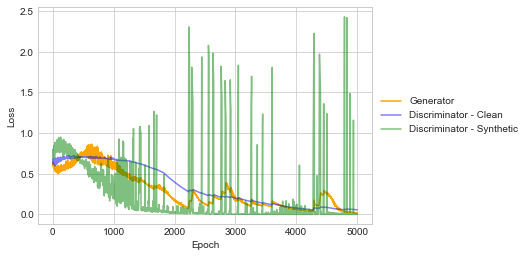

In [28]:
    gan.plot()
    from keras.utils import plot_model
    plot_model(gan.G, to_file='gen.png')
    plot_model(gan.D, to_file='dis.png')